In [1]:
import math as mt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

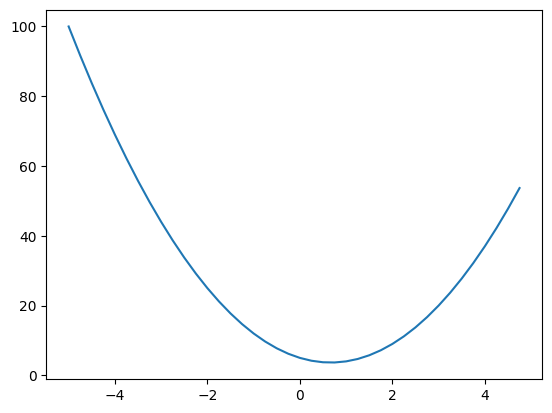

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys) # Obtenemos una parábola puesto que estamos utilizando una 
# función con x^2

Ahora, queremos saber cuál es la derivada de esta función en cada punto de ella.
Para poder tomar la derivada, la función ha de ser continua.

In [5]:
h = 0.001
x = -3.0 # Si nos fijamos en la función, si nos vamos a una 'x' negativa, la pendiente a su vez, será negativa.
(f(x + h) - f(x)) / h # Lo que estamos obteniendo aquí es la pendiente.

-21.996999999998934

In [6]:
h = 0.000001
x = 2/3 # Ahora nos estamos yendo casi el mínimo local, donde la pendiente se aproxima a 0. Sólo tenemos que observar como sería la inclinación de la pendiente en ese punto de la función.
(f(x + h) - f(x)) / h # Lo que estamos obteniendo aquí es la pendiente.

2.999378523327323e-06

In [7]:
# Vamos a aumentar un poco la complejidad.

a = 2.0
b = -3.0 
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1/h)) # Estamos obteniendo la pendiente.

d1 4.0
d2 3.997
slope -3996.003


In [137]:
class Value:

    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Ahora lo que vamos a hacer es convertir el output de los gradientes en el input de los gradientes.
        self._prev = set(_children)
        self._op = _op # Esto hace referencia al operador. 
        self.label = label # Esto hace referencia la etiqueta.

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Permitimos other si es una instancia de value, pero si no lo es, asumimos que es un número y lo metemos dentro de Value, permitiendo la operación.
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward(): # Aquí nuestra función sería coger 'out' grads y propagarlo a través de 'self' grad y 'other' grad.
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float for now'
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other): 
        return self * other**-1 # Esto es lo mismo que self/other.
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (mt.exp(2*x) - 1)/(mt.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(mt.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = [] # Orden topológico es aquel en el que las conexiones de todos los nodos van de izquierda a derecha. Todas las conexiones van en una única dirección
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [139]:
a = Value(2.0)
b = Value(4.0)
a - b # Ya hemos creado la regla de la resta

Value(data = -2.0)

In [141]:
a / b # También hemos creado la regla de la división.

Value(data = 0.5)

In [135]:
a - 4

Value(data = -2.0)

In [ ]:
a / b
a * (1/b)
a * (b**-1)

In [120]:
3 * a

Value(data = 6.0)

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Para calcular 'backpropagation' lo que vamos a hacer es empezar desde 'L' y calcular el gradiente de todos los valores intermedios hasta el principio de la red.
En 'backpropagation' lo que vamos a hacer es computar la derivada de cada uno de los nodos con respecto a L, debido a que 'L' es nuestro ouput final.

Vamos a estar muy interesados en conocer la derivada de esta función de coste L con respecto a los pesos de la red neuronal.

Lo que vamos a ejecutar aquí abajo es un primer paso de optimización.
Lo que estamos haciendo es actualizar los valores de nuestra red a través de su gradiente. 

L = e * f

Queremos saber cuanto es dL/de = f

Sabemos que la notación de la derivada es:
(f(x+h) - f(x))/h

Entonces:
((e+h)*f - e*f)/h
(e*f + h*f - e*f)/h
h*f/h
f

Por tanto, por regla de 3, si dL/de = f, dL/df = e.

Los pesos quedarían actualizados de la siguiente forma:
- W_nuevo = W_viejo - alpha * dL/dW -> Esto es si queremos actualizar el peso de la neurona correspondiente a e. | alpha = Learning rate.

Sí queremos saber cuanto es dL/dc, tenemos que hacer la regla de la cadena, es decir: dL/dc = dL/dd * dd/dc.
Por tanto, primero tenemos que saber cuanot es dd/dc.

d = c + e; la derivada de esto con respecto a c = 1.0.

(f(x+h) - f(x)/h) -> Definición de la derivada.

((c + h + e) - (c+e))/h

(c + h + e - c - e) / h

h / h = 1.0

Por tanto, ya sabemos que dd/dc = 1.0, con lo cual dd/de = 1.0. -> Estas serían derivadas locales.

Por otro lado, la notación de la regla de la cadena es: f'(g(x)) * g'(x)

Al tener ya las derivadas locales, esto sería tan fácil como hacer: 
dL/dc = dL/de * de/dc -> dL/dc = -2 * 1 = -2.0

Si quisiéramos ir más atrás, deberíamos de continuar con la regla de la cadena. 

En la primera capa tenemos a y b.

Para obtener dL/da deberíamos de obtener:
- dL/de, de/dd, dd/da.

Ahora mismo lo que nos interesa saber es cuanto es dc/da.

d = a * b

Por tanto:
- dd/da = b.
- dd/db = a.

Haciendo la regla de la cadena, sería:

dL/da = dL/de * de/dd * dd/da -> -2 * 1 * (-3) = 6.0

dL/db = dL/de * de/dd * dd/da -> -2 * 1 * (2) = -4.0


Podemos ver que el rango de esta función es [-1, 1]

In [146]:
# inputs x1, x2.
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2.
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron.
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

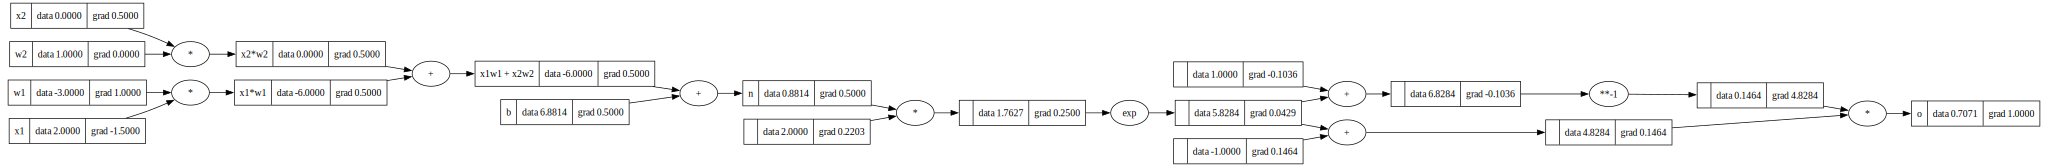

In [148]:
draw_dot(o)

Cómo podemos ver, en ambas obtenemos el mismo resultado.

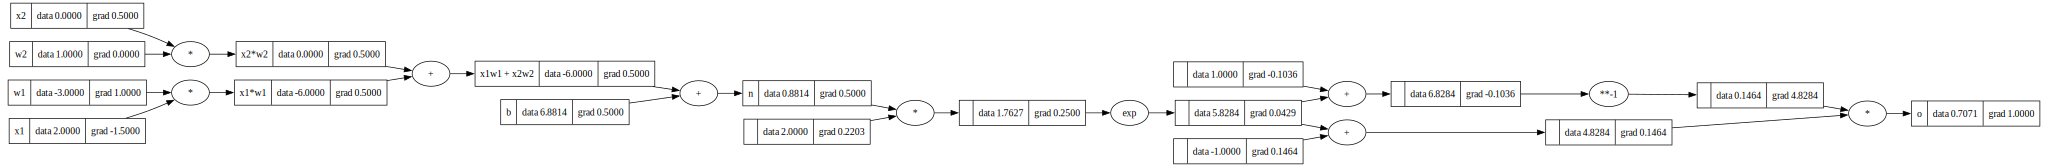

In [147]:
# inputs x1, x2.
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2.
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron.
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp() 
o = (e-1)/(e+1) #Estamos creando de forma manual la tangente hiperbólica.
# ---
o.label = 'o'
o.backward()
draw_dot(o)

In [94]:
o.backward()

In [84]:
topo = [] # Orden topológico es aquel en el que las conexiones de todos los nodos van de izquierda a derecha. Todas las conexiones van en una única dirección
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo # Con esto vamos a montar un gráfico topológico.

[Value(data = 6.881373587019543),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = -3.0),
 Value(data = 2.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

Ahora que tenemos el gradiente de 0, con la función _backward() que hemos creado, deberíamos de poder propagar el gradiente a lo largo de la red, sin la necesidad de tener que hacerlo de forma manual.

o = tanh(n)

Por tanto, ahora queremos saber cuanto es do/dn

Mirando las notaciones, podemos encontrar que: 
- do/dn = 1 - tanh(n)**2

Sabemos que o = tanh(n), por tanto:
- do/dn = 1 - o**2

In [49]:
1 - o.data ** 2 # Por tanto sabenmos que do/dn = 0.5

0.4999999999999999

In [62]:
n.grad = 0.5

Si continuamos haciendo backpropagation, la operación que tenemos en la capa anterior es una suma, por tanto, la derivada parcial de esto es = 1.0, puesto que la otra constante al ser suma, se elimina automáticamente. 
Por tanto, en base a esto, podemos concluir que: 
- dn/db = 1.0
- dn/dx1w1x2w2 = 1.0

In [63]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

Nosotros por ahora tenemos: 
do/dn
dn/db
dn/dx1w1x2w2

BUSCAMOS OBTENER:
- dn/dx1w1
- dn/dx2w2

Tendríamos que continuar la regla de la cadena

A REALIZAR:
- dx1w1x2w2/dx1w1 = 1.0, puesto que x1w1x2w2 = x1w1 + x2w2.
- dx1w1x2w2/dx2w2 = 1.0.

Por tanto, el gradiente de estos últimos también sería 0.5.

Vamos a continuar con el backpropation a lo largo de la red.

BUSCAMOS OBTENER: 
- dn/dx1
- dn/dw1
- dn/dx2
- dn/dw2

A REALIZAR:

- dx1w1/dx1 = w1 = -3.0
- dx1w1/dw1 = x1 = 2.0
- dx2w2/dx2 = w2 = 1.0
- dx2w2/dw2 = x2 = 0.0

Por tanto, ahora tendríamos que hacer lo siguiente:
- do/dx1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dx1 = 0.5 * 1.0 * 1.0 * (-3.0) = -1.5
- do/dw1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dw1 = 0.5 * 1.0 * 1.0 * 2.0 = 1.0
- do/dx2 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx2w2/dx2 = 0.5 * 1.0 * 1.0 * 1.0 = 0.0
- do/dw2 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx2w2/dw2 = 0.5 * 1.0 * 1.0 * 0.0 = 0.5

In [60]:
# inputs x1, x2.
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2.
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron.
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

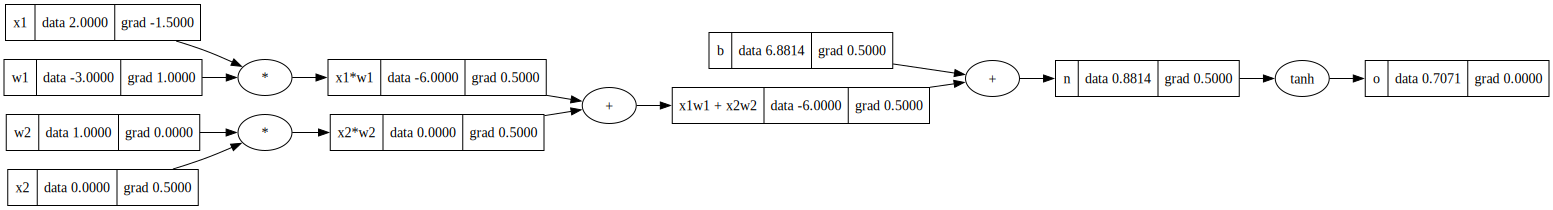

In [68]:
draw_dot(o)

In [65]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [67]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

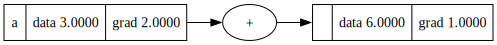

In [98]:
a = Value(3.0, label = 'a')
b = a + a; label = 'b'
b.backward()
draw_dot(b)

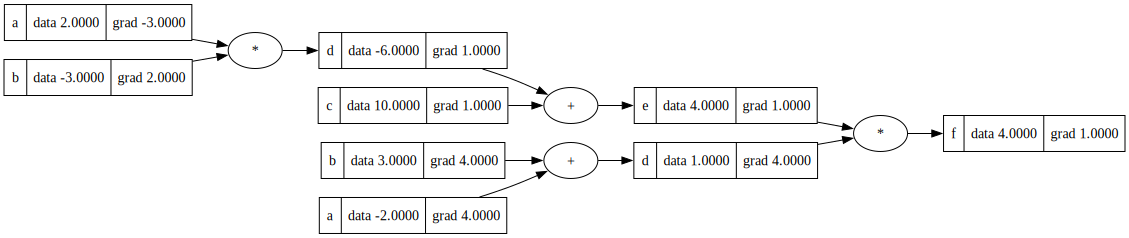

In [99]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
c = a + b; c.label = 'c'
d = a + b; d.label = 'd'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

Estamos viendo como se realiza de forma automática 'backpropagation' a lo largo de toda la red.

Ahora vamos a mostrar como podemos hacer el mismo proceso a través de la librería torch.

In [149]:
import torch

In [157]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # Esto básicamente toma un tensor simple de un elemento y devuelve el elemento eliminando el tensor.
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [161]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [159]:
o.item()

0.7071066904050358

In [160]:
o.data.item()

0.7071066904050358

Con .item() y con .data.item() obtenemos el mismo resultado.

Hemos obtenido los resultados correctos.

In [152]:
ccc = torch.Tensor([[1, 2, 3], [4, 5, 6]]) # Con la librería torch, todo se basa en tensores, que no son más que arrays unidimensionales formados por escalares.

print(ccc)
print(ccc.shape)

tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])


In [156]:
ccc1 = torch.Tensor([2.0]).double()
ccc1.dtype

torch.float64